In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.model_selection import train_test_split

from utils.data_acquisition import  fetch_housing_dataset, fetch_wine_dataset
from utils.metrics import mse
from utils.data_preparation import remove_outliers, min_max_scale
from models.models import LinearRegression, LogisticRegression
from models.optimizers import GradientDescent, StochasticGradientDescent

## Data Loading


In [92]:
SEED=0
np.random.seed(SEED)

housing_df = fetch_housing_dataset()
wine_df = fetch_wine_dataset()

# Experiment 1: Basic Performance Comparison

For both datasets, perform an 80/20 train/test split and report the performance metrics on both the training set and test set for each model. Please include metrics such as Mean Squared Error (MSE) for Linear Regression and accuracy, precision, recall, and F1-score for Logistic Regression

### Data Preparation

In [93]:
TEST_SIZE = 0.20
DEFAULT_BATCH_SIZE = 8
IQR_FACTOR=1.5 # IQR

### Data Cleaning ###
#remove outliers (but not for CHAS bc it is 1/0)
temp_df = housing_df.drop(columns='CHAS')
temp_df_cleaned = remove_outliers(temp_df, factor=IQR_FACTOR)
housing_df_cleaned = pd.concat([temp_df_cleaned, housing_df['CHAS'].loc[temp_df_cleaned.index]], axis=1)

wine_df_cleaned = remove_outliers(wine_df, factor=IQR_FACTOR)
wine_df_cleaned = wine_df.copy()

### Data Splitting ###
# perform train test split
one_hot_wine_classes = pd.get_dummies(wine_df['class']).to_numpy(dtype=int)
X_wine_train, X_wine_test, y_wine_train, y_wine_test = train_test_split(wine_df_cleaned.drop(['class'], axis=1).to_numpy(),
                                                                        one_hot_wine_classes,
                                                                        test_size=TEST_SIZE, random_seed=SEED)

X_housing_train, X_housing_test, y_housing_train, y_housing_test = train_test_split(housing_df_cleaned.drop(['MEDV'], axis=1).to_numpy(),
                                                                                    housing_df_cleaned.MEDV.to_numpy().reshape(-1,1), test_size=TEST_SIZE, random_seed=SEED)

### Data Normalization ###
# normalize data after train test split to prevent data leakage
#X_wine_train, X_wine_test = min_max_scale(X_wine_train, X_wine_test, scale=True)
X_housing_train, X_housing_test = min_max_scale(X_housing_train, X_housing_test, scale=True)

### TODO: Feature Engineering ###
# remove features?
# create non-linear features

### Linear Regression

L2 norm between best weights and SGD weights: 5430.422149186251
Mean squarred error from analytic fit: 6.947924821873906
Mean squared error from SGD with mini-batch size 8: 16.45085826197673


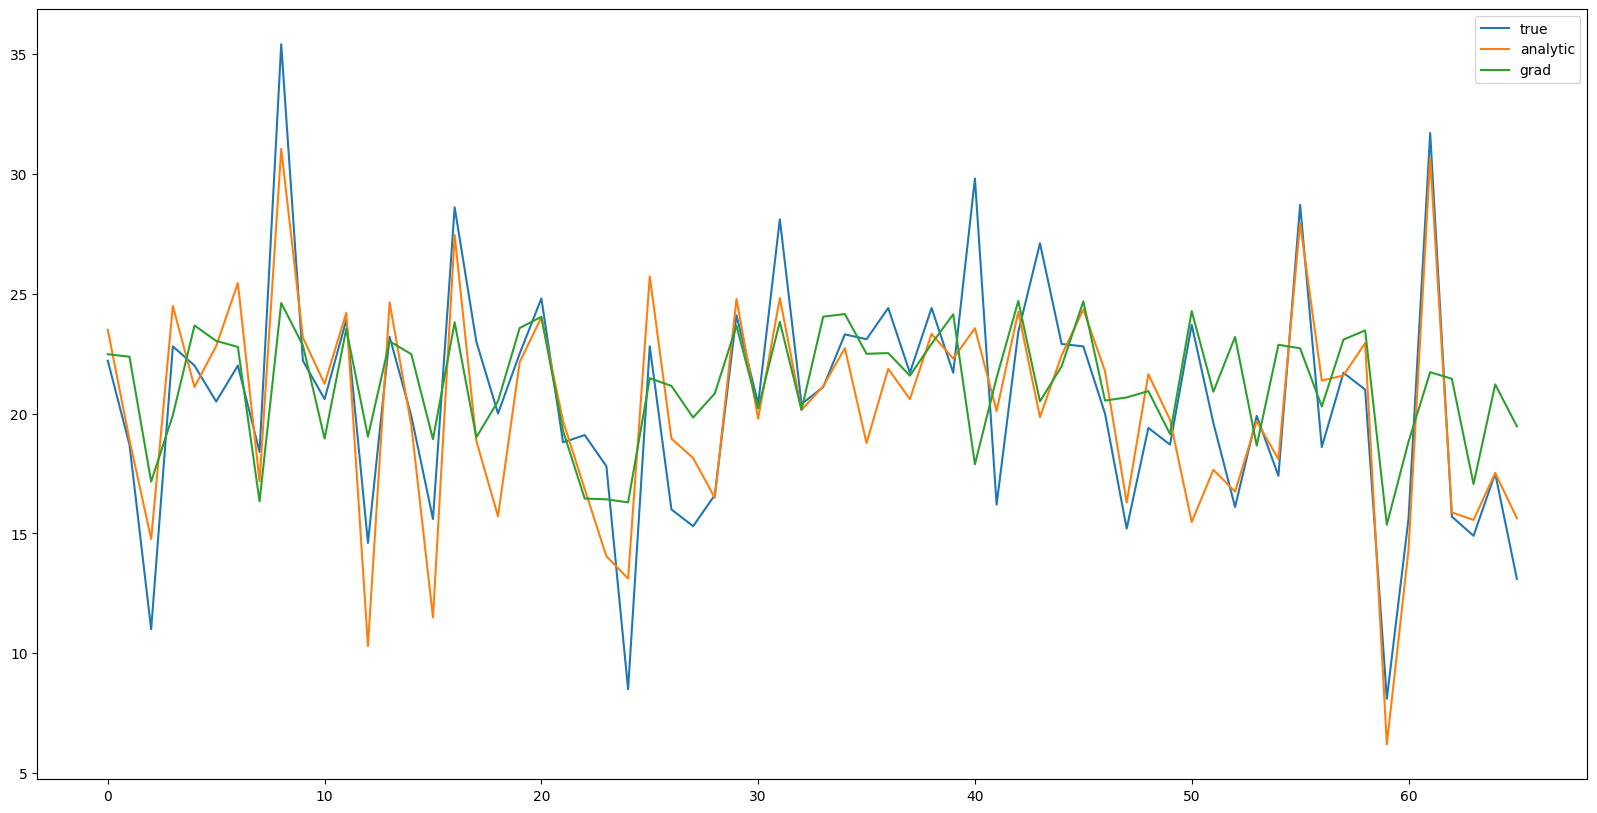

In [94]:
# Linear regression fit
lin_reg = LinearRegression()

# Analytic fit
lin_reg.fit(X_housing_train, y_housing_train, analytic_fit=True, verbose=False)
y_preds_with_analytic_fit = lin_reg.predict(X_housing_test)
min_ms_error = mse(y_housing_test, lin_reg.predict(X_housing_test))
w_analytic = np.copy(lin_reg.w)

# Mini-batch SGD fit
lin_reg.fit(X_housing_train, y_housing_train, optimizer_class=GradientDescent, batch_size=DEFAULT_BATCH_SIZE, verbose=False)
y_preds_with_grad = lin_reg.predict(X_housing_test)
ms_error = mse(y_housing_test, y_preds_with_grad)


print(f"L2 norm between best weights and SGD weights: {np.linalg.norm(w_analytic - lin_reg.w)}")
print(f"Mean squarred error from analytic fit: {min_ms_error}")
print(f"Mean squared error from SGD with mini-batch size {DEFAULT_BATCH_SIZE}: {ms_error}")

# plot results
plt.figure(figsize=(20,10))
plt.plot(y_housing_test, label='true')
plt.plot(y_preds_with_analytic_fit, label='analytic')
plt.plot(y_preds_with_grad, label='grad')
plt.legend()
plt.show()

### Logistic Regression

In [95]:
np.random.seed(0)
optimizer_kwargs = {'max_iters': 4e4,
                    'learning_rate': 0.05,
                    'verbose': False}

# Logistic regression fit
log_reg = LogisticRegression()

# Learn model parameters with gradient descent
log_reg.fit(X_wine_train, y_wine_train, optimizer_class=GradientDescent, **optimizer_kwargs)
y_wine_preds_gd = log_reg.predict(X_wine_test)
w_gd = np.copy(log_reg.w)

gd_accuracy = accuracy_score(y_wine_test, y_wine_preds_gd)
gd_recall = recall_score(y_wine_test, y_wine_preds_gd, average='weighted')
gd_precision = precision_score(y_wine_test, y_wine_preds_gd, average='weighted')
gd_f1_score = f1_score(y_wine_test, y_wine_preds_gd, average='weighted')

# Learn model parameters with stochastic gradient descent
log_reg.fit(X_wine_train, y_wine_train, optimizer_class=StochasticGradientDescent, batch_size=DEFAULT_BATCH_SIZE, **optimizer_kwargs)
y_wine_preds_sgd = log_reg.predict(X_wine_test)
w_sgd = np.copy(log_reg.w)

sgd_accuracy = accuracy_score(y_wine_test, y_wine_preds_sgd)
sgd_recall = recall_score(y_wine_test, y_wine_preds_sgd, average='weighted')
sgd_precision = precision_score(y_wine_test, y_wine_preds_sgd, average='weighted')
sgd_f1_score = f1_score(y_wine_test, y_wine_preds_sgd, average='weighted')

print("l2 norm between sgd weights and mini-batch weights: ", np.linalg.norm(w_gd - w_sgd))
print(f"Accuracy:\n \tGD: {gd_accuracy:.5g}, SGD with mini-batch of size {DEFAULT_BATCH_SIZE}: {sgd_accuracy:.5g}")
print(f"Recall:\n \tGD: {gd_recall:.5g}, SGD with mini-batch of size {DEFAULT_BATCH_SIZE}: {sgd_recall:.5g}")
print(f"Precision:\n \tGD: {gd_precision:.5g}, SGD with mini-batch of size {DEFAULT_BATCH_SIZE}: {sgd_precision:.5g}")
print(f"F1 score:\n \tGD: {gd_f1_score:.5g}, SGD with mini-batch of size {DEFAULT_BATCH_SIZE}: {sgd_f1_score:.5g}")

l2 norm between sgd weights and mini-batch weights:  549.2129432787159
Accuracy:
 	GD: 0.94286, SGD with mini-batch of size 8: 0.88571
Recall:
 	GD: 0.94286, SGD with mini-batch of size 8: 0.88571
Precision:
 	GD: 0.94694, SGD with mini-batch of size 8: 0.9102
F1 score:
 	GD: 0.94338, SGD with mini-batch of size 8: 0.8899


# Experiment 2: Cross-Validation

For both data sets, use a 5-fold cross-validation technique and report the performance metrics on both the training set and test set for each model. Again, include appropriate performance metrics for each model. Check this link for more information.

Note: 5-fold cross-validation is a technique where the dataset is divided into five equal parts (folds), and a model is trained and evaluated five times, each time using a different fold as the validation set and the remain- ing four folds for training.


### Data Preparation

In [96]:
DEFAULT_BATCH_SIZE = 8
IQR_FACTOR=1.5 # IQR

### Data Cleaning ###
#remove outliers (but not for CHAS bc it is 1/0)
temp_df = housing_df.drop(columns='CHAS')
temp_df_cleaned = remove_outliers(temp_df, factor=IQR_FACTOR)
housing_df_cleaned = pd.concat([temp_df_cleaned, housing_df['CHAS'].loc[temp_df_cleaned.index]], axis=1)

wine_df_cleaned = remove_outliers(wine_df, factor=IQR_FACTOR)
wine_df_cleaned = wine_df.copy()

X_housing = housing_df_cleaned.drop(['MEDV'], axis=1).to_numpy()
y_housing = housing_df_cleaned.MEDV.to_numpy().reshape(-1,1)

X_wine = wine_df_cleaned.drop(['class'], axis=1).to_numpy()
y_wine = pd.get_dummies(wine_df_cleaned['class']).to_numpy(dtype=int)

### Linear Regression

In [97]:
# Implementing a basic 5-fold cross validation
def k_fold_split(X, y, n_splits=5):
    fold_sizes = (len(y) // n_splits) * np.ones(n_splits, dtype=int)
    fold_sizes[:len(y) % n_splits] += 1
    current = 0
    for fold_size in fold_sizes:
        start, stop = current, current + fold_size
        train_indices = list(range(0, start)) + list(range(stop, len(y)))
        test_indices = list(range(start, stop))
        yield X[train_indices], y[train_indices], X[test_indices], y[test_indices]
        current = stop

# Initialize lists to store results
errors_analytic_train = []
errors_analytic_test = []
errors_sgd_train = []
errors_sgd_test = []

for X_train_fold, y_train_fold, X_test_fold, y_test_fold in k_fold_split(X_housing, y_housing):
    lin_reg = LinearRegression()

    # data normalization
    X_train_fold, X_test_fold = min_max_scale(X_train_fold, X_test_fold, scale=True)

    # Analytic fit
    lin_reg.fit(X_train_fold, y_train_fold, analytic_fit=True, verbose=False)
    y_preds_with_analytic_fit_train = lin_reg.predict(X_train_fold)
    y_preds_with_analytic_fit_test = lin_reg.predict(X_test_fold)
    errors_analytic_train.append(mse(y_train_fold, y_preds_with_analytic_fit_train))
    errors_analytic_test.append(mse(y_test_fold, y_preds_with_analytic_fit_test))
    w_analytic = np.copy(lin_reg.w)

    # Mini-batch SGD fit
    lin_reg.fit(X_train_fold, y_train_fold, optimizer_class=GradientDescent, batch_size=DEFAULT_BATCH_SIZE, verbose=False)
    y_preds_with_grad_train = lin_reg.predict(X_train_fold)
    y_preds_with_grad_test = lin_reg.predict(X_test_fold)
    errors_sgd_train.append(mse(y_train_fold, y_preds_with_grad_train))
    errors_sgd_test.append(mse(y_test_fold, y_preds_with_grad_test))

print("Analytic Fit Errors:")
print("Train:", errors_analytic_train)
print("Train Mean:", np.mean(errors_analytic_train))
print("Train Std:", np.std(errors_analytic_train))
print("Test:", errors_analytic_test)
print("Test Mean:", np.mean(errors_analytic_test))
print("Test Std:", np.std(errors_analytic_test))

print("\nMini-Batch SGD Errors:")
print("Train:", errors_sgd_train)
print("Train Mean:", np.mean(errors_sgd_train))
print("Train Std:", np.std(errors_sgd_train))
print("Test:", errors_sgd_test)
print("Test Mean:", np.mean(errors_sgd_test))
print("Test Std:", np.std(errors_sgd_test))

Analytic Fit Errors:
Train: [6.372192267084715, 7.342902925319603, 5.793879094396441, 6.540663300506986, 5.521731089244624]
Train Mean: 6.314273735310474
Train Std: 0.6342900330632179
Test: [7.9708137696004355, 3.77374884543282, 11.745234790995962, 8.652968753532198, 20.008474388885457]
Test Mean: 10.430248109689376
Test Std: 5.421957769396132

Mini-Batch SGD Errors:
Train: [15.272855335080337, 18.55767226444527, 14.251530114474791, 16.53152259673538, 16.771571306163885]
Train Mean: 16.277030323379932
Train Std: 1.4575104299865624
Test: [24.020576412267086, 9.088074811624477, 27.362193570033433, 16.3278879112186, 14.876141233265779]
Test Mean: 18.334974787681876
Test Std: 6.562222660531458


### Logistic Regression

In [98]:
results_gd_train = []
results_gd_test = []
results_sgd_train = []
results_sgd_test = []

for X_train_fold, y_train_fold, X_test_fold, y_test_fold in k_fold_split(X_wine, y_wine):

    log_reg = LogisticRegression()

    # GD fit
    log_reg.fit(X_train_fold, y_train_fold, optimizer_class=GradientDescent, **optimizer_kwargs)

    # metrics
    y_train_preds_gd = log_reg.predict(X_train_fold)
    results_gd_train.append(accuracy_score(y_train_fold, y_train_preds_gd))
    y_test_preds_gd = log_reg.predict(X_test_fold)
    results_gd_test.append(accuracy_score(y_test_fold, y_test_preds_gd))

    # SGD fit
    log_reg.fit(X_train_fold, y_train_fold, optimizer_class=StochasticGradientDescent, batch_size=DEFAULT_BATCH_SIZE, **optimizer_kwargs)

    # metrixs
    y_train_preds_sgd = log_reg.predict(X_train_fold)
    results_sgd_train.append(accuracy_score(y_train_fold, y_train_preds_sgd))
    y_test_preds_sgd = log_reg.predict(X_test_fold)
    results_sgd_test.append(accuracy_score(y_test_fold, y_test_preds_sgd))

# Computing mean and std for each metric
print("Gradient Descent Results:")
print(f"Train Accuracy: Mean {np.mean(results_gd_train).round(5)}, Std {np.std(results_gd_train).round(5)}")
print(f"Test Accuracy: Mean {np.mean(results_gd_test).round(5)}, Std {np.std(results_gd_test).round(5)}")

print("\nSGD Results:")
print(f"Train Accuracy: Mean {np.mean(results_sgd_train).round(5)}, Std {np.std(results_sgd_train).round(5)}")
print(f"Test Accuracy: Mean {np.mean(results_sgd_test).round(5)}, Std {np.std(results_sgd_test).round(5)}")

Gradient Descent Results:
Train Accuracy: Mean 0.91031, Std 0.06598
Test Accuracy: Mean 0.74984, Std 0.25983

SGD Results:
Train Accuracy: Mean 0.79891, Std 0.11088
Test Accuracy: Mean 0.82063, Std 0.07086


### Results

- generally good performance

# Experiment 3: Training Set Sizes
For both datasets, Sample growing subsets of the training data (20%,30%,...80%). Observe and explain how does size of training data affects the performance for both models. Plot two curves as a function of training size, one for performance in train and one for test.

### Data Preparation

In [103]:
TEST_SIZE = 0.20
DEFAULT_BATCH_SIZE = 8
IQR_FACTOR=1.5 # IQR

### Data Cleaning ###
#remove outliers (but not for CHAS bc it is 1/0)
temp_df = housing_df.drop(columns='CHAS')
temp_df_cleaned = remove_outliers(temp_df, factor=IQR_FACTOR)
housing_df_cleaned = pd.concat([temp_df_cleaned, housing_df['CHAS'].loc[temp_df_cleaned.index]], axis=1)

wine_df_cleaned = remove_outliers(wine_df, factor=IQR_FACTOR)
wine_df_cleaned = wine_df.copy()

### Data Splitting ###
# perform train test split
one_hot_wine_classes = pd.get_dummies(wine_df['class']).to_numpy(dtype=int)
X_wine_train, X_wine_test, y_wine_train, y_wine_test = train_test_split(wine_df_cleaned.drop(['class'], axis=1).to_numpy(), 
                                                                        one_hot_wine_classes, test_size=TEST_SIZE, random_state=SEED)

X_housing_train, X_housing_test, y_housing_train, y_housing_test = train_test_split(housing_df_cleaned.drop(['MEDV'], axis=1).to_numpy(),
                                                                                    housing_df_cleaned.MEDV.to_numpy().reshape(-1,1), test_size=TEST_SIZE, random_state=SEED)

### Data Normalization ###
# normalize data after train test split to prevent data leakage
#X_wine_train, X_wine_test = min_max_scale(X_wine_train, X_wine_test, scale=True)
X_housing_train, X_housing_test = min_max_scale(X_housing_train, X_housing_test, scale=True)

### Linear Regression

### Logistic Regression

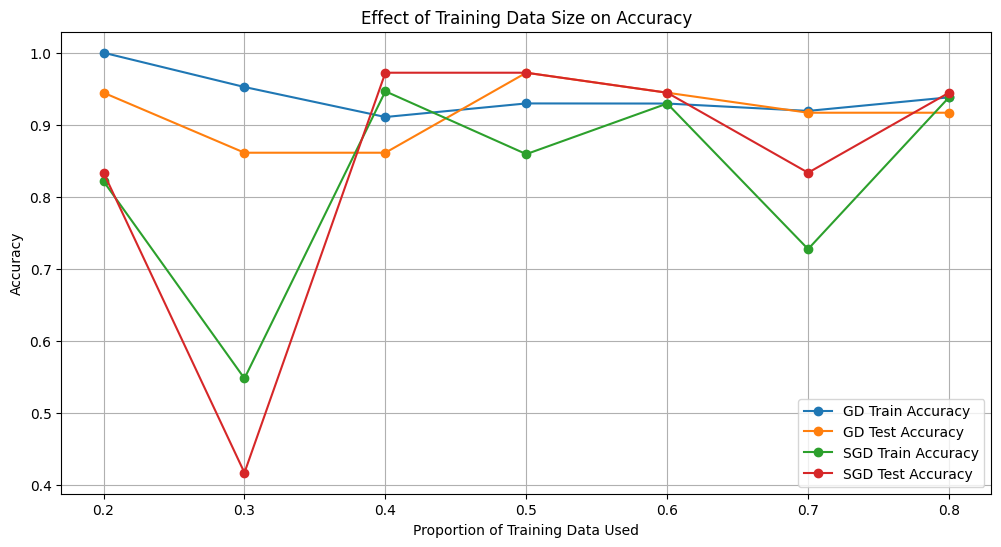

In [104]:
# sizes to sample
sizes = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

gd_train_accuracies = []
gd_test_accuracies = []
sgd_train_accuracies = []
sgd_test_accuracies = []

for size in sizes:
    # Splitting the data
    subset_size = int(size * X_wine_train.shape[0])
    X_train_subset = X_wine_train[:subset_size]
    y_train_subset = y_wine_train[:subset_size]
    
    # Training with Gradient Descent
    log_reg.fit(X_train_subset, y_train_subset, optimizer_class=GradientDescent, **optimizer_kwargs)
    gd_train_accuracies.append(accuracy_score(y_train_subset, log_reg.predict(X_train_subset)))
    gd_test_accuracies.append(accuracy_score(y_wine_test, log_reg.predict(X_wine_test)))
    
    # Training with SGD
    log_reg.fit(X_train_subset, y_train_subset, optimizer_class=StochasticGradientDescent, batch_size=DEFAULT_BATCH_SIZE, **optimizer_kwargs)
    sgd_train_accuracies.append(accuracy_score(y_train_subset, log_reg.predict(X_train_subset)))
    sgd_test_accuracies.append(accuracy_score(y_wine_test, log_reg.predict(X_wine_test)))

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(sizes, gd_train_accuracies, '-o', label="GD Train Accuracy")
plt.plot(sizes, gd_test_accuracies, '-o', label="GD Test Accuracy")
plt.plot(sizes, sgd_train_accuracies, '-o', label="SGD Train Accuracy")
plt.plot(sizes, sgd_test_accuracies, '-o', label="SGD Test Accuracy")
plt.xlabel("Proportion of Training Data Used")
plt.ylabel("Accuracy")
plt.title("Effect of Training Data Size on Accuracy")
plt.legend()
plt.grid(True)
plt.show()

### Results

- x
- y
- z

# Experiment 4: Minibatch Sizes
For both datasets, try out growing minibatch sizes, e.g., 8, 16, 32, 64, and 128. Compare the convergence speed and final performance of different batch sizes to the fully batched baseline. Which configuration works the best among the ones you tried?
Note: This is for SGD only (Task2, third main task).

### Data Preparation

### Linear Regression

### Logistic Regression